In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.methods import *
from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.kernels import get_kernel
from sgptools.kernels.attentive import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import Dataset

np.random.seed(1234)
tf.random.set_seed(1234)

2025-11-28 12:47:23.102219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 12:47:23.118826: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 12:47:23.326266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 12:47:23.505174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764355643.664309   14465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764355643.70

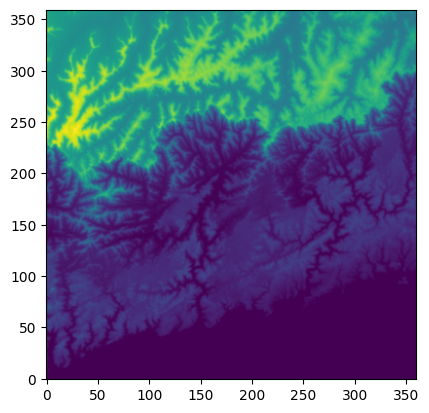

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-11-28 12:47:44.233326: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()

# Train GP/Kernel 
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=np.linspace(1, 10, 10)),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

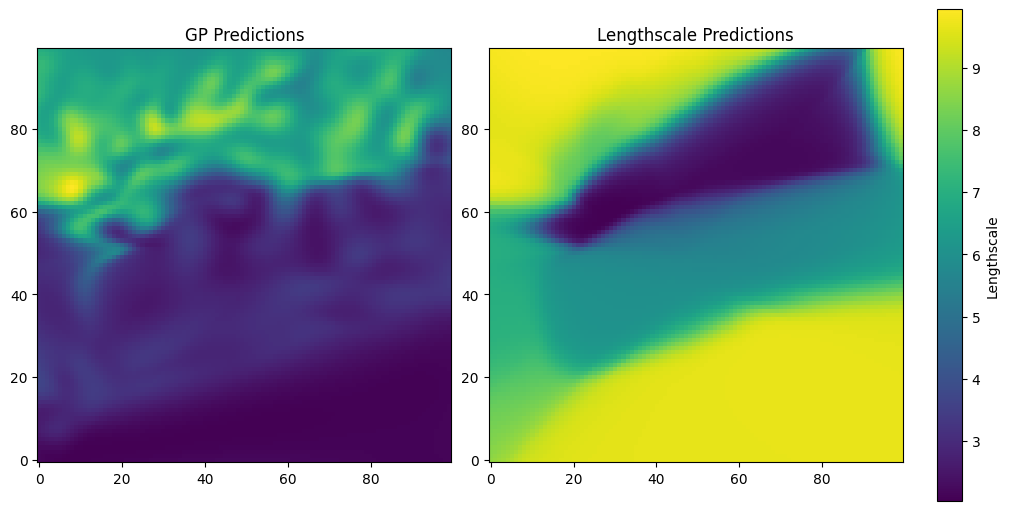

In [3]:
# Plot GP prediction and lengthscale map
X_test, _ = dataset.get_test()
grid_x, grid_y = np.mgrid[min(X_test[:, 0]):max(X_test[:, 0]):100j, 
                          min(X_test[:, 1]):max(X_test[:, 1]):100j]
X_test = np.stack([grid_x, grid_y], axis=-1)
x_dim, y_dim = X_test.shape[:2]
X_test = X_test.reshape(-1, 2).astype(X_train.dtype)

mean, std = model.predict_f(X_test)
lengthscale_preds = kernel.get_lengthscales(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(lengthscale_preds.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [4]:
# ---------------- Generate X_candidates (grid with spacing set to minimum radius) ----------------

radii = kernel.get_lengthscales(X_train)/2
min_r = np.min(radii) * 0.5
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

# Define the number of points in each dimension
num_points_x = np.ceil((x_max-x_min)/min_r).astype(int)
num_points_y = np.ceil((y_max-y_min)/min_r).astype(int)

# Create 1D arrays for x and y coordinates
x_coords = np.linspace(x_min, x_max, num_points_x)
y_coords = np.linspace(y_min, y_max, num_points_y)

# Generate the 2D grid coordinates
xx, yy = np.meshgrid(x_coords, y_coords)
X_candidates = np.stack([xx.ravel(), yy.ravel()], axis=-1)
X_candidates = X_candidates.astype(X_train.dtype)
print(f"Num candidates: {len(X_candidates)}")

Num candidates: 4624


In [5]:
cmodel = get_method('GreedyCoverage')(num_sensing=600,
                                      X_objective=X_test,
                                      kernel=kernel,
                                      X_candidates=X_candidates)
X_sol = cmodel.optimize()[0]
print(len(X_sol))

184


In [6]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

sol_path, _ = run_tsp(X_sol, time_limit=30)
sol_lengthscales = kernel.get_lengthscales(X_sol)

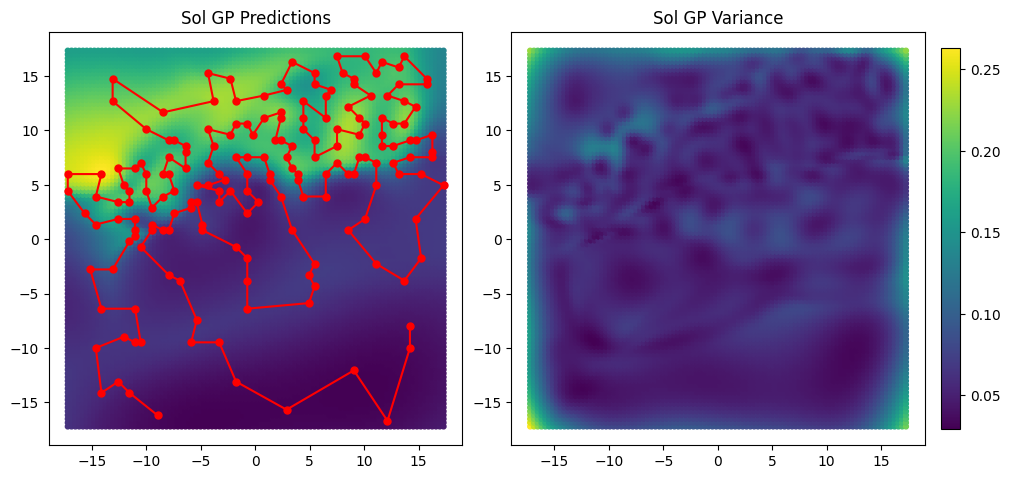

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_test[:, 0], X_test[:, 1], c=mean.numpy(), s=12)
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=var.numpy(), s=12)
#axes[1].scatter(X_candidates[:, 0], X_candidates[:, 1], c='r', s=1)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()

In [8]:
cmodel = get_method('GCBCoverage')(num_sensing=600,
                                   X_objective=X_test,
                                   kernel=kernel,
                                   X_candidates=X_sol)
X_sol = cmodel.optimize()[0]
len(X_sol)

183

In [9]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

sol_path, _ = run_tsp(X_sol, time_limit=30)
sol_lengthscales = kernel.get_lengthscales(X_sol)

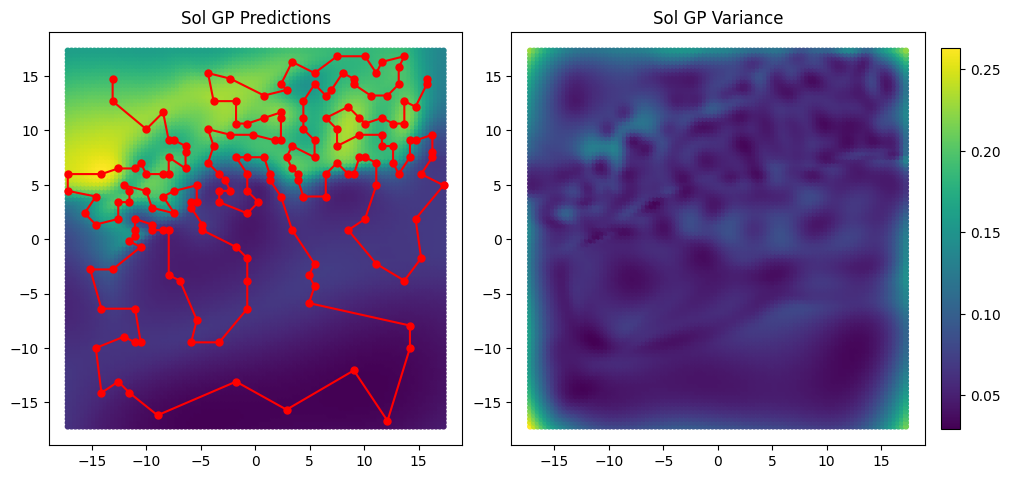

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_test[:, 0], X_test[:, 1], c=mean.numpy(), s=12)
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=var.numpy(), s=12)
#axes[1].scatter(X_candidates[:, 0], X_candidates[:, 1], c='r', s=1)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()